In [1]:
import pandas as pd 
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse as ph

%matplotlib inline

# A/B-тестирование

## Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных 
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

## Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему? 
- Имеются ли различия в показателях и с чем они могут быть связаны? 
- Являются ли эти различия статистически значимыми? 
- Стоит ли запускать новую механику на всех пользователей? 

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

## Реализация

### Импорт наборов данных

In [2]:
groups = pd.read_csv('/Users/vitaly/Documents/KarpovCourses/!KC_Фин_Проект/Проект_2_groups.csv',
                     sep = ';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.dtypes

id      int64
grp    object
dtype: object

In [5]:
groups.shape

(74484, 2)

Переименуем столбец _id_ в _student_id_ для удобства объединений

In [6]:
groups = groups.rename(columns = {'id': 'student_id'})

In [7]:
active_studs = pd.read_csv('/Users/vitaly/Documents/KarpovCourses/!KC_Фин_Проект/Проект_2_active_studs.csv')

In [8]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [9]:
active_studs.dtypes

student_id    int64
dtype: object

In [10]:
active_studs.shape

(8341, 1)

In [11]:
checks = pd.read_csv('/Users/vitaly/Documents/KarpovCourses/!KC_Фин_Проект/Проект_2_checks.csv',
                     sep = ';')

In [12]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [13]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [14]:
checks.shape

(541, 2)

_Проверим, почему столбцу rev присвоен тип float64_

In [15]:
checks.rev.unique()

array([ 990.    ,  690.    ,  630.    ,  580.    ,  290.    , 1140.    ,
       1900.0001,  199.    ,  398.    , 1830.    , 1900.    , 3260.    ,
       2910.    , 2820.    , 2099.    , 3660.    , 1530.    , 2900.    ,
       1980.    , 1160.    ,  870.    ,  840.    , 2890.    , 1180.    ,
        880.    , 3040.    ,  796.    , 4650.    , 2190.    , 1729.    ,
       1388.    ,  590.    , 2220.    ,  489.    , 1050.    , 1968.    ,
       1339.    ,  597.    , 1039.    ])

_Колонке rev (Revenue) соответствует тип float64, когда на деле ей достаточно int64 - заменим_

In [16]:
checks.rev = checks.rev.astype('int')

In [17]:
checks.head()

,student_id,rev
0,1627,990
1,3185,690
2,25973,690
3,26280,690
4,100300,990


### EDA

_Оценим размеры контрольной и тестовой групп:_

1. Проверим дубликаты в таблице groups

In [18]:
print('В таблице groups {} дубликатов'.format(groups[groups.duplicated()].shape[0]))

В таблице groups 0 дубликатов


2. Оценим размеры контрольной и тестовой групп

In [19]:
groups.groupby('grp').agg({'student_id': 'count'}) \
                     .rename(columns = {'id': 'count_of_students'})

,student_id
grp,
A,14671
B,59813


In [20]:
groups.groupby('grp').agg({'student_id': 'count'}) \
                     .rename(columns = {'id': 'percent_of_students'}) \
                     .apply(lambda x: x / groups.shape[0]) \
                     .mul(100) \
                     .round(1)         

,student_id
grp,
A,19.7
B,80.3


- _Контрольная группа составляет 19,7% (14671 пользователь)_ 
- _Тестовая - 80,3% (59813 польз.)_

_Проверим наличие дубликатов в таблице active_studs_

In [21]:
print('В таблице active_studs {} дубликатов' \
      .format(active_studs[active_studs.duplicated(subset = 'student_id')].shape[0]))

В таблице active_studs 0 дубликатов


_Проверим наличие дубликатов в таблице checks по столбцу student_id_

In [22]:
print('В таблице checks {} дубликатов' \
      .format(checks[checks.duplicated(subset = 'student_id')].shape[0]))

В таблице checks 0 дубликатов


### Выбор метрик для оценивания эксперимента

_Предложенные наборы данных располагают информацией об активных пользователях и прибыли (Revenue) с каждого из них, поэтому можно использовать следующий набор метрик:_

1) CR в покупку \
2) ARPPU \
3) ARPU 

_Конверсия в покупку (CR) интересна в первую очередь, так как тестируется новая механика оплаты услуг на сайте, успех которой лучше всего отобразим количеством покупателей._ \
_Средний доход с покупателя (ARPPU) и Средний доход с пользователя (ARPU) отразят то, как новая механика поощряет добавление товаров в корзину и удобство новой механики оплаты, её "привлекательность"._



### Рассчёт метрик

_1) По очереди соединим датафреймы с таблицей __groups__, приняв её за опорную, так как в ней больше всего записей_

_1.1 Добавим записи об активных пользователях в период проведения эксперимента_

Чтобы это отобразить, введём переменную __is_active__ и присвоим ей константу 1  в датафрейме __active_studs__, после чего объединим с __groups__ методом __left__. Так, получившиеся NaN будут отображать отсутствие активности - заполним их нулями. Получится бинарная переменная (1 - заходил на сайт, 0 - не заходил)

In [23]:
active_studs['is_active'] = 1

In [24]:
groups_active_studs = groups.merge(active_studs, 
                                   on = 'student_id', 
                                   how = 'left') \
                                  .fillna(0)

In [25]:
groups_active_studs.head()

,student_id,grp,is_active
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


In [26]:
groups_active_studs.is_active.value_counts()

is_active
0.0    66156
1.0     8328
Name: count, dtype: int64

_1.2 Добавим записи о покупках пользователей, таким же образом заведя бинарную переменную __is_pay___

In [27]:
checks['is_pay'] = 1

In [28]:
full_merged_df = groups_active_studs.merge(checks, 
                                           on = 'student_id', 
                                           how = 'left') \
                                          .fillna(0)

In [29]:
full_merged_df.head()

,student_id,grp,is_active,rev,is_pay
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


_1.3 Убедимся в том, что каждый покупатель заходил на сайт в период проведения эксперимента. Если это не так, записи с этими пользователями стоит исключить, так как нас интересует успех новой механики оплаты: если пользователь не заходил на сайт, он её не видел._

In [30]:
full_merged_df.groupby('is_active') \
              .agg({'is_pay': 'sum'}) \
              .rename(columns = {'is_pay': 'count_of_payments'})

,count_of_payments
is_active,
0.0,149.0
1.0,391.0


Видно, что 149 пользователей совершили покупку в период эксперимента, не заходя на сайт - создадим новый датафрейм без записей с этими пользователями для корректности анализа и столбца __is_active__ (в нём нет смысла)

In [31]:
clear_df = full_merged_df.query('is_active == 1')[['student_id', 'grp', 'rev', 'is_pay']]

_2) Рассчитаем CR в покупку для каждой группы_

In [32]:
CR_pay_active = clear_df.groupby('grp').agg({'is_pay': 'sum',
                                         'student_id': 'count'}) \
                                       .rename(columns = {'student_id': 'count_of_users'})

In [33]:
CR_pay_active

,is_pay,count_of_users
grp,,
A,78.0,1535
B,313.0,6793


In [34]:
CR_pay_active['CR (%)'] = CR_pay_active['is_pay'] / CR_pay_active['count_of_users'] * 100

In [35]:
CR_pay_active

,is_pay,count_of_users,CR (%)
grp,,,
A,78.0,1535,5.081433
B,313.0,6793,4.607684


In [36]:
CR_by_group = CR_pay_active[['CR (%)']]

In [37]:
CR_by_group

,CR (%)
grp,
A,5.081433
B,4.607684


3) Рассчитаем ARPPU и ARPU

In [38]:
ARP_rev_pay_counts = clear_df.groupby('grp').agg({'rev': 'sum',
                                               'is_pay': 'sum',
                                           'student_id': 'count'}) \
                                            .rename(columns = {'is_pay': 'count_pay_users',
                                                           'student_id': 'count_users'})

In [39]:
ARP_rev_pay_counts

,rev,count_pay_users,count_users
grp,,,
A,72820.0,78.0,1535
B,393074.0,313.0,6793


In [40]:
ARP_rev_pay_counts['ARPPU'] = ARP_rev_pay_counts['rev'] / ARP_rev_pay_counts['count_pay_users']

In [41]:
ARP_rev_pay_counts['ARPU'] = ARP_rev_pay_counts['rev'] / ARP_rev_pay_counts['count_users']

In [42]:
ARP_rev_pay_counts

,rev,count_pay_users,count_users,ARPPU,ARPU
grp,,,,,
A,72820.0,78.0,1535,933.589744,47.439739
B,393074.0,313.0,6793,1255.827476,57.864566


In [43]:
ARP_by_group = ARP_rev_pay_counts[['ARPPU', 'ARPU']]

In [44]:
ARP_by_group

,ARPPU,ARPU
grp,,
A,933.589744,47.439739
B,1255.827476,57.864566


In [45]:
# объединим таблицы с метриками

metrics = CR_by_group.merge(ARP_by_group, on = 'grp')

In [46]:
metrics

,CR (%),ARPPU,ARPU
grp,,,
A,5.081433,933.589744,47.439739
B,4.607684,1255.827476,57.864566


In [47]:
# Проверка правильности рассчёта ARPU
# Для этого перемножим CR с ARPPU

metrics_check = metrics.copy()
metrics_check['ARPU_check_calculation'] = metrics_check['CR (%)'] * metrics_check['ARPPU'] / 100

In [48]:
metrics_check

,CR (%),ARPPU,ARPU,ARPU_check_calculation
grp,,,,
A,5.081433,933.589744,47.439739,47.439739
B,4.607684,1255.827476,57.864566,57.864566


_4) Выводы_

In [49]:
metrics

,CR (%),ARPPU,ARPU
grp,,,
A,5.081433,933.589744,47.439739
B,4.607684,1255.827476,57.864566


_Конверсия у тестовой группы меньше на 0.5%, однако ARPPU и ARPU больше на 322.2 и 10,5 у.е. соответственно. \
Можно сделать вывод, что новая механика оплаты услуг лучше мотивирует добавлять больше товаров в корзину и/или более дорогие, однако хуже доводит до покупки._ 

_Проверим статистически!_


### Проверка статистической значимости отличий

#### CR

_При рассчёте конверсии используется категориальная переменная - кол-во пользователей совершивших целевое действие. Эти данные категориальные, поэтому применим тест Хи-квадрат, чтобы проверить зависимость группы и кол-ва покупателей._

_H0: между группами и кол-вом покупателей НЕТ зависимости_ \
_H1: между группами и кол-вом покупателей ЕСТЬ зависимость_

_alpha = 0.05_

In [50]:
hi2_crosstab = pd.crosstab(clear_df['grp'], 
                           clear_df['is_pay'])

In [51]:
hi2_crosstab

is_pay,0.0,1.0
grp,,
A,1457,78
B,6480,313


In [52]:
alpha = 0.05

In [53]:
stat, p, dof, expected = stats.chi2_contingency(hi2_crosstab)

In [54]:
if p > alpha:
    print(f'Различия статистически НЕ значимы, p-value: {p}')
else:
    print(f'Различия статистически значимы, p-value: {p}')

Различия статистически НЕ значимы, p-value: 0.46803677583199144


_Вывод: различия в конверсии между группами статистически не значимы, так как p-value > 0.05_

#### ARPPU

_Исследуем распределения дохода с покупателей, чтобы выбрать правильный статистический критерий для сравнения групп._

In [55]:
clear_df.head()

,student_id,grp,rev,is_pay
1,1627,A,990.0,1.0
10,2085,B,0.0,0.0
12,2215,B,0.0,0.0
43,3391,A,0.0,0.0
45,3401,B,0.0,0.0


Распределение выручки с покупателей

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

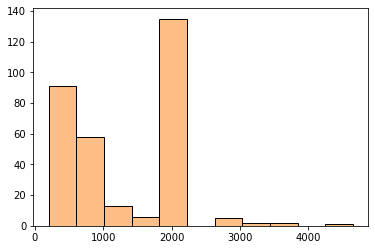

In [56]:
sns.histplot(x = 'rev',
             hue = 'grp',
             data = clear_df.query('is_pay == 1'),
             kde = True)

In [ ]:
sns.boxplot(x = 'rev',
            y = 'grp',
            data = clear_df.query('is_pay == 1'))

_Видим, что распределения не являются нормальными, не одинаковые, поэтому применим бустреп, а затем t-критерием сравним средние средних полученных выборок между группами_

_Оставим в датафрейме __clear_df__ только нужные столбцы для скорости выполнения_

In [ ]:
clear_df.head()

In [ ]:
arppu_data_bootstrap = clear_df.query('is_pay == 1')[['grp', 'rev']]

In [ ]:
arppu_data_bootstrap.head()

_Выполним бутстреп_

Контрольная группа

In [ ]:
arppu_means_A = []

data = arppu_data_bootstrap.query('grp == "A"')
n = 10000          # кол-во симуляций

for i in range(n):
    sample_data = data.sample(frac = 1, replace = True)
    sample_mean = sample_data.rev.mean()
    arppu_means_A.append(sample_mean)

In [ ]:
sns.histplot(arppu_means_A)

Тестовая группа

In [ ]:
arppu_means_B = []

data = arppu_data_bootstrap.query('grp == "B"')
n = 10000          # кол-во симуляций

for i in range(n):
    sample_data = data.sample(frac = 1, replace = True)
    sample_mean = sample_data.rev.mean()
    arppu_means_B.append(sample_mean)

In [ ]:
sns.histplot(arppu_means_B)

_Допущением t-критерия является гомогенность дисперсий - проверим это. Проведём тест Левена_

Тест Левена

_H0: дисперсии в группах гомогенны_ \
_H1: дисперсии в группах гетерогенны_

In [ ]:
clear_df.head()

In [ ]:
lev_group_A = clear_df.query('grp == "A" & is_pay == 1').rev
lev_group_B = clear_df.query('grp == "B" & is_pay == 1').rev

In [ ]:
stat, p = stats.levene(lev_group_A,
                       lev_group_B)

In [ ]:
alpha = 0.05

In [ ]:
if p > alpha:
    print(f'Нулевая гипотеза НЕ отклоняется, дисперсии гомогенны, p-value: {p}')
else:
    print(f'Нулевая гипотеза отклоняется, дисперсии гетерогенны, p-value: {p}')

_Вывод: дисперсии в группах гомогенны, так как p-value > 0.05_

_Используем t-критерий для сравнения ARPPU между группами_

_H0: ARPPU между группами отличается незначимо \
H1: ARPPU между группами отличается значимо_

In [ ]:
stats.ttest_ind(arppu_means_A,
                arppu_means_B)

_Вывод: Принимаем альтернативную гипотезу о том, что ARPPU статистически значимо отличается между группами, так как p-value < 0.05_

#### ARPU

_Исследуем распределения дохода с покупателей, чтобы выбрать правильный статистический критерий для сравнения групп._

In [ ]:
clear_df.head()

Распределение выручки с пользователей

In [ ]:
sns.histplot(x = 'rev',
             hue = 'grp',
             data = clear_df)

In [ ]:
sns.boxplot(x = 'rev',
            y = 'grp',
            data = clear_df)

_Воспользуемся тем же алгоритмом сравнения, что и с ARPPU_

_Оставим в датафрейме __clear_df__ только нужные столбцы для скорости выполнения_

In [ ]:
arpu_data_bootstrap_A = clear_df.query('grp == "A"')[['grp', 'rev']]
arpu_data_bootstrap_B = clear_df.query('grp == "B"')[['grp', 'rev']]

_Бутстреп_

Контрольная группа

In [ ]:
arpu_means_A = []

data = arpu_data_bootstrap_A
n = 10000          # кол-во симуляций

for i in range(n):
    sample_data = data.sample(frac = 1, replace = True)
    sample_mean = sample_data.rev.mean()
    arpu_means_A.append(sample_mean)

In [ ]:
sns.histplot(arpu_means_A)

Тестовая группа

In [ ]:
arpu_means_B = []

data = arpu_data_bootstrap_B
n = 10000          # кол-во симуляций

for i in range(n):
    sample_data = data.sample(frac = 1, replace = True)
    sample_mean = sample_data.rev.mean()
    arpu_means_B.append(sample_mean)

In [ ]:
sns.histplot(arpu_means_B)

_Средние средних распределены нормально, поэтому мы можем применить t-критерий, однако следует проверить гомогенность дисперсий. Проведём тест Левена_

_H0: дисперсии в группах гомогенны_ \
_H1: дисперсии в группах гетерогенны_

In [ ]:
stat, p = stats.levene(arpu_data_bootstrap_A.rev,
                       arpu_data_bootstrap_B.rev)

In [ ]:
alpha = 0.05

In [ ]:
if p > alpha:
    print(f'Нулевая гипотеза НЕ отклоняется, дисперсии гомогенны, p-value: {p}')
else:
    print(f'Нулевая гипотеза отклоняется, дисперсии гетерогенны, p-value: {p}')

_Вывод: дисперсии в группах гомогенны, так как p-value > 0.05_

_Используем t-критерий для сравнения ARPU между группами_

_H0: ARPU между группами отличается незначимо \
H1: ARPU между группами отличается значимо_

In [ ]:
stats.ttest_ind(arpu_means_A,
                arpu_means_B)

_Вывод: Принимаем альтернативную гипотезу о том, что ARPU статистически значимо отличается между группами, так как p-value < 0.05_

In [ ]:
metrics

__Финальный вывод:__ новая механика оплаты лучше предыдущей поскольку с ней статистически значимо улучшились такие метрики, как ARPPU и ARPU - средняя выручка увеличилась. Выкатываем новую механику на всех пользователей. 

# SQL

## "Очень усердные ученики"

### Условие

_Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной"._

_Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин._

### Задача

_Дана таблица default.peas:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|timesst||timestamp||Время решения карточки|
|correct||bool||Правильно ли решена горошина?|
|subject||text||Дисциплина в которой находится горошина|


_Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов._ \
_Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц._

### Реализация

_Настройки подключения к базе данных_

In [ ]:
connection_default = {'host':     'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user':     'student', 
                      'password': 'dpo_python_2020'}

**Запрос к БД**


In [ ]:
query_1 = """

WITH 
    (
    SELECT 
        month(max(timest))  
     FROM 
        default.peas
    ) as last_date              -- последняя дата в таблице
    
SELECT
    COUNT(*) as count_of_students                     
FROM
    (
    SELECT 
        st_id,
        sum(correct) as count_of_gor
    FROM
        default.peas
    WHERE
        month(timest) = last_date     
    GROUP BY 
        st_id
    HAVING 
        count_of_gor >= 20                             -- отсечение количества правильно решённых задач меньше 20
    )

"""

In [ ]:
result_query_1 = ph.read_clickhouse(query = query_1, 
                               connection = connection_default)

In [ ]:
result_query_1

In [ ]:
print(f'{result_query_1.iloc[0][0]} студентов являются очень усердными, то есть решили как минимум 20 задач за текущий месяц')

## Оптимизация воронки

### Условие

_Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты._

### Задача

_Даны таблицы_ 

_default.peas:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|timesst||timestamp||Время решения карточки|
|correct||bool||Правильно ли решена горошина?|
|subject||text||Дисциплина в которой находится горошина|


\
_default.studs:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|test_grp||text||Метка ученика в данном эксперименте|


\
_default.final_project_check:_

|Название атрибута||Тип атрибута||Смысловое значение|
|---||---||---|
|st_id||int||ID ученика|
|saletime||timestamp||Время покупки|
|money||int||Цена, по которой приобрели данный курс|
|subject||text|||

_Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:_

- _ARPU_ 
- _ARPAU_
- _CR в покупку_ 
- _СR активного пользователя в покупку_ 
- _CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике_

_ARPU считается относительно всех пользователей, попавших в группы._

_Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах._

_Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике._

### Реализация

**Запрос к БД**

In [ ]:
query_2 = """

SELECT
    test_grp as group,
    SUM(money) / COUNT(DISTINCT studs.st_id) as ARPU,
    sumIf(money, tasks_done > 10) / uniqIf(studs.st_id, tasks_done > 10) AS ARPAU,
    uniqIf(studs.st_id, money > 0) / COUNT(DISTINCT(studs.st_id)) * 100 AS CR,
          
        uniqIf(studs.st_id, money > 0 AND tasks_done > 10) 
        /
        uniqIf(studs.st_id, tasks_done > 10) * 100 AS CR_act,
        
        uniqIf(studs.st_id, money > 0 AND math_tasks_done >= 2 AND subject = 'Math')
        /
        uniqIf(studs.st_id, math_tasks_done >= 2) * 100 AS CR_act_math
FROM
    default.studs as studs
        LEFT JOIN
    default.final_project_check as check
        ON
    studs.st_id = check.st_id
        LEFT JOIN
        (
        SELECT
            st_id,
            sum(correct) AS tasks_done,
            sumIf(correct, subject = 'Math') AS math_tasks_done
        FROM
            default.peas as peas
        GROUP BY
            st_id
        ) as peas
        ON
    studs.st_id = peas.st_id
GROUP BY 
    group

"""

In [ ]:
result_query_2 = ph.read_clickhouse(query = query_2, 
                               connection = connection_default)

In [ ]:
result_query_2

# Python

## Функция подгрузки информации и пересчёта метрик

### Задача
_Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики._

### Реализация

In [ ]:
def updating_info(new_df_link):
     
    groups_add = pd.read_csv(new_df_link).rename(columns = {'id': 'student_id'})
    
    # Объединение таблиц вертикально
    frames = [groups, groups_add] 
    groups_concat = pd.concat(frames).drop_duplicates() 
    
    # Объединение таблиц для рассчёта
    groups_active_studs = groups_concat.merge(active_studs, 
                                              on = 'student_id', 
                                              how = 'left') \
                                             .fillna(0)
    
    full_merged_df = groups_active_studs.merge(checks, 
                                               on = 'student_id', 
                                               how = 'left') \
                                              .fillna(0)
    
    clear_df = full_merged_df.query('is_active == 1')[['student_id', 'grp', 'rev', 'is_pay']]
    
    # Конверсия
    CR_pay_active = clear_df.groupby('grp').agg({'is_pay': 'sum',
                                             'student_id': 'count'}) \
                                           .rename(columns = {'student_id': 'count_of_users'})
    
    CR_pay_active['CR (%)'] = round(CR_pay_active['is_pay'] / CR_pay_active['count_of_users'] * 100, 
                                    1)
    
    CR_by_group = CR_pay_active[['CR (%)']]
    
    # ARPPU и ARPU
    ARP_rev_pay_counts = clear_df.groupby('grp').agg({'rev': 'sum',
                                                   'is_pay': 'sum',
                                               'student_id': 'count'}) \
                                                .rename(columns = {'is_pay': 'count_pay_users',
                                                               'student_id': 'count_users'})
    
    ARP_rev_pay_counts['ARPPU'] = round(ARP_rev_pay_counts['rev'] / ARP_rev_pay_counts['count_pay_users'],
                                        1)
    ARP_rev_pay_counts['ARPU'] = round(ARP_rev_pay_counts['rev'] / ARP_rev_pay_counts['count_users'],
                                       1)
    ARP_by_group = ARP_rev_pay_counts[['ARPPU', 'ARPU']]
    
    # Объеднинение таблиц с метриками
    metrics = CR_by_group.merge(ARP_by_group, on = 'grp') 
    
    return metrics

Дополненные данные

In [ ]:
updating_info('/Users/vitaly/Documents/KarpovCourses/!KC_Фин_Проект/Проект_2_group_add.csv')

Изначальные данные

In [ ]:
metrics

## Функция визуализации метрик

### Задача
_Реализуйте функцию, которая будет строить графики по получаемым метрикам._

### Реализация

In [ ]:
def visual_metrics():

    # Параметры холста
    plt.figure(figsize = (17, 4))

    # конверсия
    plt.subplot(1, 3, 1)
    plt.bar(data = metrics.reset_index(),
            x = 'grp',
            height = 'CR (%)',
            color = 'brown'
           )
    plt.title('Конверсия')
    plt.ylabel('Значение(%)')

    # ARPPU
    plt.subplot(1, 3, 2)
    plt.bar(data = metrics.reset_index(),
            x = 'grp',
            height = 'ARPPU',
            color = 'green'
           )
    plt.title('ARPPU')
    plt.ylabel('Значение')

    # ARPU
    plt.subplot(1, 3, 3)
    plt.bar(data = metrics.reset_index(),
            x = 'grp',
            height = 'ARPU',
            color = 'green'
           )
    plt.title('ARPU')
    plt.ylabel('Значение')

In [ ]:
visual_metrics()